In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi, isnan, isinf
from scipy.optimize import minimize
from scipy.linalg import inv
from scipy import stats
from statsmodels.tsa.stattools import adfuller

In [2]:
#perform lag optimization

# GARCH-MIDAS

Key points:
- Model uses mean-reverting unit daily GARCH process to fit the short-lived component (fast) of the volatility; MIDAS polynomial to depict the secular component driven by some lower frequency variables (slow)


$$r_{i,t} = \mu + \sqrt{\tau_ig_{i,t}}\epsilon_{i,t}, \forall i = 1, 2, ..., N_t$$

whereby
- $r_{i,t}$: price return (log or compound return?)
- $\mu$: mean daily return conditional on information set $\Psi_{i-1}$ 
- $N_t$: number of days in month t
- $g_{i,t}$: short-term component of the conditional probability
- $\tau_t$: secular component


Garch(1,1) process:
$$g_{i,t} = (1 - \alpha - \beta) + \alpha \frac{(r_{i-1,t}-\mu)^2}{\tau_t} + \beta g_{i-1,t}$$


MIDAS regression (which one? hmmm....):
$$\tau_t = m^2 + \underbrace{\theta_R^2 \sum_{k=1}^{K_r} \phi_k(\omega_1, \omega_2) RV_{t-k}}_{\text{Realized vol component}} + \underbrace{\theta_c \sum_{k=1}^{K_c}\phi_k(\omega_{1,c}, \omega_{2,c})X_{t-k}}_{\text{CPU Index or Climate related disaster}} $$

$$log(\tau_t) = m + \underbrace{\theta_R \sum_{k=1}^{K_r} \phi_k(\omega_1, \omega_2) RV_{t-k}}_{\text{Realized vol component}} + \underbrace{\theta_c \sum_{k=1}^{K_c}\phi_k(\omega_{1,c}, \omega_{2,c})X_{t-k}}_{\text{CPU Index or Climate related disaster}} $$

where:
- $RV_t$: realized volatility of daily returns in month $t$
- $K_r$: number of periods over which the realized volatility is smoothed
- $\theta$: measures the contribution of RV to the secular component


Original Study:
- In-sample estimation: January 1, 1991 - December 31, 2021
- Out-sample test: January 1, 2022 - July 29, 2022
- Forecasts in this study were conducted with a rolling-window approach—i.e., using data from January 1, 1991, to December 31,
2021, to project the price volatility on January 1, 2022; using data from January 2, 1991, to January 1, 2022, to project the volatility
on January 2, 2022; and so on.

Further reference:
https://github.com/blake-marsh/GARCH_replication


In [3]:
# params : [mu, theta, omega_2, alpha, beta, m]
def beta_lag_wt_scheme(K, omega_2, omega_1 = 1):
    '''
    Function to generate an array of factor weights phis
    Args:
        K (int) : the number of lags.
        omega_1 (float, optional) : The first parameter of the weighting scheme. Defaults to 1.
        omega_2 (float) : The second parameter of the weighting scheme.

    Returns:
        ndarray: A column vector representing the weighting scheme.

    '''
    j_vec = np.arange(K,0,-1)
    denom =\
    (
        np
        .sum(
            (j_vec/(K+1)) ** (omega_1 - 1.0)
            * (1.0 - j_vec/(K+1)) ** (omega_2 - 1.0)
        )
    )

    numer =\
    (
        (j_vec/(K+1)) ** (omega_1 - 1.0)
        * (1.0 - j_vec/(K+1)) ** (omega_2 - 1.0)
    )

    return (numer / denom).reshape(j_vec.shape[0],1)

In [4]:
def get_onefactor_tau(params, X, K):
    '''
    Function to return an array of taus based on one-factor GARCH-MIDAS model.
    Args:
        params (ndarray) : An array of the 6 parameters required for the model
        X (ndarray) : A matrix of the factor values.
        K (int) : The number of lags.

    Returns:
        mu (float) : The parameter mu.
        alpha (float) : The parameter alpha.
        beta (float) : The parameter beta.
        tau (ndarray) : An array of Tau values.
        T (int) : The size of the Tau array.
    '''
    mu, alpha, beta, theta, omega, m = params
    
    #tau = m + theta * np.dot(X, beta_lag_wt_scheme(K, omega))
    ln_tau = m + theta * np.dot(X, beta_lag_wt_scheme(K, omega))
    
    T = ln_tau.size

    return mu, alpha, beta, np.exp(ln_tau), T

In [5]:
def get_twofactor_tau(params, X, K):
    '''
    Function to return an array of taus based on two-factor GARCH-MIDAS model.
    Args:
        params (ndarray) : An array of the 8 parameters required for the model
        X (ndarray) : A matrix of the factor values.
        K (int) : The number of lags.

    Returns:
        mu (float) : The parameter mu.
        alpha (float) : The parameter alpha.
        beta (float) : The parameter beta.
        tau (ndarray) : An array of Tau values.
        T (int) : The size of the Tau array.
    '''
    mu, alpha, beta, theta1, theta2, omega1, omega2, m = params
    X1, X2 = X
    
#     tau =\
#     (
#         m 
#         + theta1 * np.dot(X1, beta_lag_wt_scheme(K, omega1))
#         + theta2 * np.dot(X2, beta_lag_wt_scheme(K, omega2))
#     )
    
    ln_tau =\
    (
        m 
        + theta1 * np.dot(X1, beta_lag_wt_scheme(K, omega1))
        + theta2 * np.dot(X2, beta_lag_wt_scheme(K, omega2))
    )
    T = ln_tau.size

    return mu, alpha, beta, np.exp(ln_tau), T

In [6]:
def get_threefactor_tau(params, X, K):
    '''
    Function to return an array of taus based on three-factor GARCH-MIDAS model.
    Args:
        params (ndarray) : An array of the 10 parameters required for the model
        X (ndarray) : A matrix of the factor values.
        K (int) : The number of lags.

    Returns:
        mu (float) : The parameter mu.
        alpha (float) : The parameter alpha.
        beta (float) : The parameter beta.
        tau (ndarray) : An array of Tau values.
        T (int) : The size of the Tau array.
    '''
    mu, alpha, beta, theta1, theta2,theta3, omega1, omega2, omega3, m = params
    X1, X2, X3 = X
    #log_tau = m**2 + theta**2 * np.dot(X, beta_lag_wt_scheme(K, omega))
#     tau =\
#     (
#         m 
#         + theta1 * np.dot(X1, beta_lag_wt_scheme(K, omega1))
#         + theta2 * np.dot(X2, beta_lag_wt_scheme(K, omega2))
#         + theta3 * np.dot(X3, beta_lag_wt_scheme(K, omega3))
#     )
    
    ln_tau =\
    (
        m 
        + theta1 * np.dot(X1, beta_lag_wt_scheme(K, omega1))
        + theta2 * np.dot(X2, beta_lag_wt_scheme(K, omega2))
        + theta3 * np.dot(X3, beta_lag_wt_scheme(K, omega3))
    )
    T = ln_tau.size

    return mu, alpha, beta, np.exp(ln_tau), T

In [7]:
def get_fourfactor_tau(params, X, K):
    '''
    Function to return an array of taus based on three-factor GARCH-MIDAS model.
    Args:
        params (ndarray) : An array of the 10 parameters required for the model
        X (ndarray) : A matrix of the factor values.
        K (int) : The number of lags.

    Returns:
        mu (float) : The parameter mu.
        alpha (float) : The parameter alpha.
        beta (float) : The parameter beta.
        tau (ndarray) : An array of Tau values.
        T (int) : The size of the Tau array.
    '''
    mu, alpha, beta, theta1, theta2, theta3, theta4, omega1, omega2, omega3, omega4, m = params
    
    X1, X2, X3, X4 = X
    #log_tau = m**2 + theta**2 * np.dot(X, beta_lag_wt_scheme(K, omega))
    ln_tau = (
    m 
    + theta1 * np.dot(X1, beta_lag_wt_scheme(K, omega1))
    + theta2 * np.dot(X2, beta_lag_wt_scheme(K, omega2))
    + theta3 * np.dot(X3, beta_lag_wt_scheme(K, omega3))
    + theta4 * np.dot(X4, beta_lag_wt_scheme(K, omega4))
    )
    
    #tau =\
    
    #(
    #   m 
    #   + theta1 * np.dot(X1, beta_lag_wt_scheme(K, omega1))
    #    + theta2 * np.dot(X2, beta_lag_wt_scheme(K, omega2))
    #    + theta3 * np.dot(X3, beta_lag_wt_scheme(K, omega3))
    #    + theta4 * np.dot(X4, beta_lag_wt_scheme(K, omega4))
    #)
    
    T = ln_tau.size

    return mu, alpha, beta, np.exp(ln_tau), T

In [8]:
def GARCH_MIDAS(params, returns, X, K, get_tau = get_onefactor_tau, full_output = False):
    '''
    Function representing the GARCH-MIDAS model.
    Args:
        params (ndarray) : An array of the parameters required for the model
        X (ndarray or tuple) : A set of matrices of the factor values. If there are more than one factor, a tuple is used.
        K (int) : The number of lags.
        get_tau (obj, optional) : The function required to get the required tau array. Defaults to one factor model, get_onefactor_tau
        full_output (bool, optional) : If True, it returns a set of outputs -loglik, logliks, e, tau, gt, ht, T. Otherwise, returns loglik. Defaults to False.

    Returns:
        mu (float) : The parameter mu.
        alpha (float) : The parameter alpha.
        beta (float) : The parameter beta.
        tau (ndarray) : An array of Tau values.
        T (int) : The size of the Tau array.
    '''

    mu, alpha, beta, tau, T = get_tau(params, X, K)

    ## define the squared errors
    e = returns[-tau.shape[0]:] - mu
    e2 = e**2
    e2 = e2.flatten()

    # define g
    gt = np.array([tau[0]])

    for t in range(1, tau.size):
        
        gt =\
            np.append(gt, 
                      (1 - alpha - beta) + alpha*(e2[t-1]/tau[t]) + beta*gt[t-1])
    
    gt = gt.reshape(-1,1)
    ht = np.multiply(tau,gt).flatten()

    # log likelihood
    logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))
    
    if isnan(logliks.sum()) or isinf(logliks.sum()):
        loglik = 1E10
    else:
        loglik = logliks.sum()

    
    if full_output == True:
        return -loglik, logliks, e, tau, gt, ht, T

    else:
        return loglik



In [9]:
def hessian_matrix(fun, theta, args, epsilon=1e-05):
    '''
    Function to calculate the hessian matrix of the model.

    '''
    f = fun(theta, *args)
    h_ = epsilon*np.abs(theta)
    
    h = np.diag(h_)
    K = theta.shape[0]
    
    fp = np.zeros(K)
    fm = np.zeros(K)
    for i in range(K):
        fp[i] = fun(theta+h[i], *args)
        fm[i] = fun(theta-h[i], *args)
        
    fpp = np.zeros((K,K))
    fmm = np.zeros((K,K))
    for i in range(K):
        for j in range(i,K):
            fpp[i,j] = fun(theta + h[i] + h[j],  *args)
            fpp[j,i] = fpp[i,j]
            fmm[i,j] = fun(theta - h[i] - h[j],  *args)
            fmm[j,i] = fmm[i,j]
            
    hh = (np.diag(h))
    hh = hh.reshape((K,1))
    hh = np.dot(hh,hh.T)
    
    H = np.zeros((K,K))
    for i in range(K):
        for j in range(i,K):
            H[i,j] = (fpp[i,j] - fp[i] - fp[j] + f 
                       + f - fm[i] - fm[j] + fmm[i,j])/hh[i,j]/2
            H[j,i] = H[i,j]
    
    return H

def summary_stats(fun, T, params, args, labels, epsilon=1e-05):
    '''
    Function to calculate the p-values of the parameters given the model.

    '''
    H = hessian_matrix(fun, params, args, epsilon = epsilon)
    vcv = inv(H/T)/T
    
    eigenvalues, eigenvectors = np.linalg.eig(vcv)
    eigenvalues[eigenvalues < 0] = 0
    lambda_matrix = np.diag(eigenvalues)
    vcv = np.dot(np.dot(eigenvectors, lambda_matrix), np.linalg.inv(eigenvectors))

    se = np.diag(vcv)**0.5
    t = params/se
    pvalues = stats.t.sf(np.abs(t),args[0].size - params.shape[0])

    df =\
    (
        pd
        .DataFrame(
            data = {'values': params, 
                    'p-val': pvalues}, 
            index = labels
            ).T
    )
    
    

    return df


---

# Data Processing
- Read csvs containing CPU, EMDAT, Futures data

In [10]:
# Climate Policy Uncertainty Index
# source: https://www.policyuncertainty.com/climate_uncertainty.html
cpu = pd.read_csv('cpu.csv', sep=',')

# EM-DAT International disaster database
# Source: https://www.emdat.be/
emdat = pd.read_csv('EMDAT.csv', encoding_errors='ignore')

# Natural Gas Futures price
# Source: https://www.eia.gov/dnav/ng/hist/rngc1d.htm
natgas_futures = pd.read_csv('natgas_futures_price.csv', sep=',')
natgas_futures_bef_1994 = pd.read_csv("ngfutures.csv")

# WTI data 
WTI = pd.read_csv("Macrotrends-crude-oil-prices-daily.csv", skiprows=9).set_index("Date")
WTI.index = pd.to_datetime(WTI.index)
WTI_ret = np.log(WTI["Closing Value"]/WTI["Closing Value"].shift()).dropna() * 100
WTI_ret.name = "WTI_ret"


In [11]:
#concatentating the Natural Gas data

start_date = pd.to_datetime("1991-01-01")
end_date = pd.to_datetime("2023-07-01")

natgas_futures_bef_1994['Date']= pd.to_datetime(natgas_futures_bef_1994['Date'],format='%d/%m/%Y')
natgas_futures_bef_1994.set_index('Date', inplace=True)
natgas_futures_bef_1994.rename(columns={"Price": "natgas_future_price"}, inplace=True)

natgas_futures['Date']= pd.to_datetime(natgas_futures['Date'],format='%d/%m/%y')
natgas_futures.set_index('Date', inplace=True)

date_end = pd.to_datetime("1994-01-13")
natgas_future_prior1994 = natgas_futures_bef_1994[(natgas_futures_bef_1994.index.year >= 1991) & (natgas_futures_bef_1994.index <= date_end)]
natgas_futures = pd.concat([natgas_future_prior1994, natgas_futures], axis=0)
natgas_futures = natgas_futures[(natgas_futures.index > start_date) 
                                  &
                              (natgas_futures.index < end_date)]

In [12]:
# Combine Dataframe

# Prepare CPU index data
cpu[['date', 'cpu_index', 'old_cpu_index']] = cpu['date,cpu_index,old_cpu_index'].str.split(',', expand=True)
cpu['date']= pd.to_datetime(cpu['date'],format='%b-%y')
cpu.set_index('date', inplace=True)
cpu.drop(columns=['date,cpu_index,old_cpu_index','old_cpu_index'], inplace=True)
cpu['cpu_index'] = pd.to_numeric(cpu['cpu_index'])

cpu = cpu.diff()
cpu.iloc[0] = cpu.iloc[1]

cpu = cpu[(cpu.index >= start_date)
           &
        (cpu.index <= end_date)]

# Process EM-DAT data
emdat = emdat[['Country', 'Subregion', 'Region', 
               'Disaster Group', 'Disaster Subgroup', 
               'Disaster Type','Start Year', 'Start Month', 
               'End Year', 'End Month']]
emdat.dropna(inplace=True)

# Key date should be based on the start date of the disaster, when market may react
emdat['Date'] =\
    pd\
    .to_datetime(
        emdat['Start Year'].astype(str) 
        + '-' 
        + emdat['Start Month'].astype(int).astype(str).str.zfill(2))

# Create a df with monthly frequencies as series
emdat_mthly_freq =\
(
    emdat
        .groupby(by = 'Date')
        .count()
        [['Disaster Group']]
        .rename(columns = {'Disaster Group' : 'Monthly_Disaster_Freq'})
)


emdat_mthly_freq = emdat_mthly_freq.diff()
emdat_mthly_freq.iloc[0] = emdat_mthly_freq.iloc[1]

emdat_mthly_freq = emdat_mthly_freq[(emdat_mthly_freq.index >= start_date)
                                   &
                                   (emdat_mthly_freq.index <= end_date)]


#WTI return 


# Log returns rescaled to 100
natgas_futures['daily_return'] =\
np.log(
    natgas_futures['natgas_future_price']/
    natgas_futures['natgas_future_price'].shift()
) * 100

# Consolidating the three data series into single dataframe 
natgas_futures['YYYY-MM'] = natgas_futures.index.to_period('M')
cpu['YYYY-MM'] = cpu.index.to_period('M')
emdat_mthly_freq['YYYY-MM'] = emdat_mthly_freq.index.to_period('M')

data =\
    natgas_futures\
        .merge(
            cpu,
            how = 'left',
            on = 'YYYY-MM'
        )\
        .merge(
            emdat_mthly_freq,
            how = 'left',
            on = 'YYYY-MM'
        )

# data = (
#     natgas_futures
#     .merge(cpu, how='left', left_index=True, right_index=True)
#     .merge(emdat_mthly_freq, how='left', left_index=True, right_index=True)
#     .merge(WTI_ret, how='left', left_index=True, right_index=True)
# ).drop(columns= ["YYYY-MM_x", "YYYY-MM_y", "YYYY-MM"])

data.index = natgas_futures.index
data.dropna(inplace = True)
data.head()

,natgas_future_price,daily_return,YYYY-MM,cpu_index,Monthly_Disaster_Freq
Date,,,,,
1991-01-03,1.782,-2.767194,1991-01,23.102703,0.0
1991-01-04,1.743,-2.212856,1991-01,23.102703,0.0
1991-01-07,1.785,2.381065,1991-01,23.102703,0.0
1991-01-08,1.786,0.056007,1991-01,23.102703,0.0
1991-01-09,1.728,-3.301381,1991-01,23.102703,0.0


In [13]:
from statsmodels.tsa.stattools import adfuller

def get_stats_ADF(series):
    # Ensure the series is converted to an array of values
    result_stat = adfuller(series.values)

    # Extract and print the test statistic and p-value
    print("ADF Statistic is {:.3f}".format(result_stat[0]))
    print("p-value is {:.4f}".format(result_stat[1]))

    # Extract the critical values
    critical_values = result_stat[4]
    print("critical values: ")
    print(critical_values)

    # Compare the p-value to the critical values
    significance_levels = [1, 5, 10]  # You can adjust these as needed

    for level in significance_levels:
        if result_stat[0] < critical_values[f"{level}%"]:
            print("Null hypothesis is rejected, and the series is stationary at {}% significance level.".format(level))
        else:
            print("Null hypothesis is not rejected, and the series has a unit root (non-stationary) at {}% significance level.".format(level))


get_stats_ADF(WTI_ret)

ADF Statistic is -17.107
p-value is 0.0000
critical values: 
{'1%': -3.4310302253006775, '5%': -2.861840617797508, '10%': -2.5669300137393205}
Null hypothesis is rejected, and the series is stationary at 1% significance level.
Null hypothesis is rejected, and the series is stationary at 5% significance level.
Null hypothesis is rejected, and the series is stationary at 10% significance level.


In [14]:
#no differencing required as WTI_ret has no unit root and is stationary
WTI_ret = WTI_ret[(WTI_ret.index >= start_date)
                 &
                 (WTI_ret.index <= end_date)]

In [15]:
#rename column
diff_cpu = cpu['cpu_index'].diff().to_frame().rename(columns={"cpu_index": "diff_cpu"})
diff_emdat_mthly_freq = emdat_mthly_freq[["Monthly_Disaster_Freq"]].diff().rename(
    columns={"Monthly_Disaster_Freq": "diff_monthly_disaster_freq"})

# Resample to daily frequency and forward fill to propagate the last available value to fill gaps
diff_cpu_daily = diff_cpu.resample("B").ffill()
diff_emdat_freq_daily = diff_emdat_mthly_freq.resample("B").ffill()
WTI_ret = WTI_ret.resample("B").ffill()

#isolate natgas_future["daily_return"] into a Series
natgas_futures_ret = natgas_futures["daily_return"]
natgas_futures_ret.iloc[0] = 0

#aligh cpu and emdat index to natgas future
diff_cpu_daily = diff_cpu_daily.loc[natgas_futures_ret.index]
diff_emdat_freq_daily = diff_emdat_freq_daily.loc[natgas_futures_ret.index]
WTI_ret = WTI_ret.loc[natgas_futures_ret.index]

#ffill
natgas_futures_ret_ = natgas_futures["daily_return"].ffill()
diff_cpu_daily_ = diff_cpu_daily["diff_cpu"].ffill()
diff_emdat_freq_daily_ = diff_emdat_freq_daily["diff_monthly_disaster_freq"].ffill()

#imputate missing values with median values
natgas_futures_ret_ = natgas_futures["daily_return"].fillna(natgas_futures["daily_return"].median(), inplace=False)
diff_cpu_daily_ = diff_cpu_daily["diff_cpu"].fillna(diff_cpu_daily["diff_cpu"].median(), inplace=False)
diff_emdat_freq_daily_ = diff_emdat_freq_daily["diff_monthly_disaster_freq"].fillna(
    diff_emdat_freq_daily["diff_monthly_disaster_freq"].median(), inplace=False)





/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_4165/4067385603.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  natgas_futures_ret.iloc[0] = 0


In [16]:
data2 = pd.concat([natgas_futures_ret_, diff_cpu_daily_, diff_emdat_freq_daily_, WTI_ret], axis=1)

In [17]:
data2["YYYY-MM"] = data2.index.to_period("M")
data2


,daily_return,diff_cpu,diff_monthly_disaster_freq,WTI_ret,YYYY-MM
Date,,,,,
1991-01-02,0.000000,2.833306,1.0,-7.092592,1991-01
1991-01-03,-2.767194,2.833306,1.0,-3.529327,1991-01
1991-01-04,-2.212856,2.833306,1.0,-2.891863,1991-01
1991-01-07,2.381065,2.833306,1.0,9.098925,1991-01
1991-01-08,0.056007,2.833306,1.0,0.913248,1991-01
...,...,...,...,...,...
2023-06-26,2.246471,-11.633345,10.0,0.533565,2023-06
2023-06-27,-1.008291,-11.633345,10.0,-2.180953,2023-06
2023-06-28,-5.965242,-11.633345,10.0,2.224091,2023-06


In [18]:
# Train-test split
data_train = data2[data2.index < pd.to_datetime("2023-07-01")].copy()
data_test = data2[data2.index > pd.to_datetime("2019-07-01")].copy()

In [19]:
def get_realized_variance(data, target):
    factor =\
    (
        data[[target]]
        .resample('M')
        .agg(lambda x: (x ** 2).sum())
        .rename(columns = {target : 'realized_variance'})
    ).iloc[1:]

    return factor

def get_factors(data, target, K, fun = None):
    '''
    Function to derive the factor values required.

    Args:
        data (DataFrame) : The dataframe containing the original data.
        target (string) : The name of the target factor.
        K (int) : The number of lags.
        fun (obj, optional) : The function to use to derive the factor values. Defaults to None

    returns:
        ndarray : The derived matrix of factor values.
    '''
    if fun:
        factor = fun(data, target)
        target = 'realized_variance'

    else:
        factor =\
        (
            data[[target]]
            .resample('M')
            .mean()
        ).iloc[1:]

    for i in range(1,K+1):
        factor[f'{target}_lag_{str(i).zfill(2)}'] =\
            factor[f'{target}'].shift(i)
        
    factor.dropna(inplace = True)
    factor['YYYY-MM'] = factor.index.to_period('M')

    X =\
    (
        np.array(
            data[['YYYY-MM']]
            .merge(factor,
                how = 'left',
                on = 'YYYY-MM')
            .dropna()
            .iloc[:,:1:-1]
        )
    )

    return X

---
## One-factor GARCH-MIDAS 

### Model 1: Realized Variance

In [20]:
X1_train = get_factors(data_train, 'daily_return', 36, fun = get_realized_variance)
X1_test  = get_factors(data_test, 'daily_return', 36, fun = get_realized_variance)

In [21]:
#testing
# to optimize for lags, i need to prepare X_train and X_test for each lag.

#using dictionary to contain various lagged data
X1_train_dict = {}
X1_test_dict = {}
X1_train_list = [0] * (12)

lag_variable = np.arange(3,37,3)

In [22]:
def get_X_dict(train_data, test_data, data_column, K, pri_func, sec_func = get_factors):
    for k in K:
        X1_train_dict[f"data_column{k}"] = sec_func(train_data, data_column, k, pri_func)
        X1_test_dict[f"data_column{k}"] = sec_func(test_data, data_column, k, pri_func)
    return X1_train_dict, X1_test_dict
        
X_train_lags, X_test_lags = get_X_dict(data_train, data_test, "daily_return", lag_variable, pri_func = get_realized_variance)

In [23]:
## initial values - mu, alpha, beta, theta, omega, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 1, -2])

returns_train = np.array(data_train[['daily_return']])

def get_opt_MLE(target_data, X_train_lags, K): 
    #target_data is returns_train
    
    results_list = []
    
    for k in K:

        result = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                          args = (target_data, X_train_lags[f"data_column{k}"], k)) ## Limited Memory BFGS
        results_list.append(result)
    
    return pd.DataFrame(results_list, index = lag_variable)


In [24]:
results_pd = get_opt_MLE(returns_train, X_train_lags, lag_variable)

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_4165/2876430366.py:33: RuntimeWarning: divide by zero encountered in true_divide
  (1 - alpha - beta) + alpha*(e2[t-1]/tau[t]) + beta*gt[t-1])
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_4165/2876430366.py:33: RuntimeWarning: overflow encountered in true_divide
  (1 - alpha - beta) + alpha*(e2[t-1]/tau[t]) + beta*gt[t-1])
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_4165/2876430366.py:36: RuntimeWarning: invalid value encountered in multiply
  ht = np.multiply(tau,gt).flatten()
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_4165/2876430366.py:33: RuntimeWarning: overflow encountered in double_scalars
  (1 - alpha - beta) + alpha*(e2[t-1]/tau[t]) + beta*gt[t-1])
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_4165/2876430366.py:39: RuntimeWarning: invalid value encountered in log
  logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/

In [25]:
results_pd.to_excel("params-realised volatility.xlsx")

In [26]:
results_pd #lag 36 gives the best minimised value from obj function

,fun,jac,nfev,njev,nit,status,message,x,success,hess_inv
3,21055.715900,"[0.005820766090371567, 0.10550138546119095, 0....",476,68,53,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.04444453668333559, 0.09576079621946419, 0.9...",True,<6x6 LbfgsInvHessProduct with dtype=float64>
6,20925.858512,"[0.0007275957612964458, 0.367435859709665, 0.4...",525,75,64,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.05750975147883992, 0.0850394431395299, 0.92...",True,<6x6 LbfgsInvHessProduct with dtype=float64>
9,20751.739218,"[-0.08694769347492529, -1.2230884755880136, -1...",581,83,67,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.05086977477572168, 0.09033974845860851, 0.9...",True,<6x6 LbfgsInvHessProduct with dtype=float64>
12,75319.814723,"[-1.1204974725787535, -386194.5517414861, -342...",147,21,0,2,ABNORMAL_TERMINATION_IN_LNSRCH,"[0.0005, 0.09, 0.9, 0.1, 1.0, -2.0]",False,<6x6 LbfgsInvHessProduct with dtype=float64>
15,76927.362263,"[-0.6897607818212067, -382953.4924276489, -338...",147,21,0,2,ABNORMAL_TERMINATION_IN_LNSRCH,"[0.0005, 0.09, 0.9, 0.1, 1.0, -2.0]",False,<6x6 LbfgsInvHessProduct with dtype=float64>
18,75925.077461,"[-0.5034962668990243, -380078.83142196503, -33...",147,21,0,2,ABNORMAL_TERMINATION_IN_LNSRCH,"[0.0005, 0.09, 0.9, 0.1, 1.0, -2.0]",False,<6x6 LbfgsInvHessProduct with dtype=float64>
21,74781.535564,"[-0.2866727299974214, -376424.07570988283, -33...",147,21,0,2,ABNORMAL_TERMINATION_IN_LNSRCH,"[0.0005, 0.09, 0.9, 0.1, 1.0, -2.0]",False,<6x6 LbfgsInvHessProduct with dtype=float64>
24,73595.280760,"[-0.0320142135022501, -373730.26736194384, -32...",147,21,0,2,ABNORMAL_TERMINATION_IN_LNSRCH,"[0.0005, 0.09, 0.9, 0.1, 1.0, -2.0]",False,<6x6 LbfgsInvHessProduct with dtype=float64>
27,72687.605583,"[-0.024738255888102353, -370121.19156697905, -...",147,21,0,2,ABNORMAL_TERMINATION_IN_LNSRCH,"[0.0005, 0.09, 0.9, 0.1, 1.0, -2.0]",False,<6x6 LbfgsInvHessProduct with dtype=float64>
30,71779.829769,"[-0.01600710675112505, -366912.19157759834, -3...",147,21,0,2,ABNORMAL_TERMINATION_IN_LNSRCH,"[0.0005, 0.09, 0.9, 0.1, 1.0, -2.0]",False,<6x6 LbfgsInvHessProduct with dtype=float64>


In [27]:
#find the minimum value of the objective function among all lags
index_min = results_pd["fun"].idxmin()

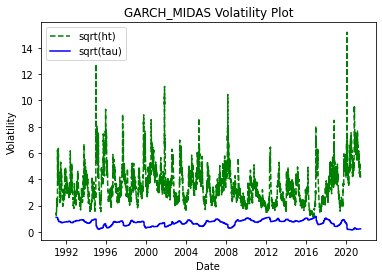

In [28]:
loglik, logliks, e, tau1, gt, ht, T =  GARCH_MIDAS(results_pd["x"].loc[index_min], 
                                                  returns_train, 
                                                  X_train_lags[f"data_column{index_min}"], 
                                                  index_min, 
                                                  full_output=True)

#Generate an array of time intervals
start_date = pd.to_datetime("1991-01-01")
time_intervals = np.array([t for t in range(T)])

#Generate an array of dates with business day frequency for the US
date_array = pd.date_range(start=start_date, periods=T, freq='B')

#Create a single figure with multiple subplots
fig, ax = plt.subplots()

#Plot the data on the same axis
ax.plot(date_array, np.sqrt(ht), 'g--', label='sqrt(ht)')
ax.plot(date_array, np.sqrt(tau1), 'b-', label='sqrt(tau)')

#Add labels, title, legend, etc.
ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
ax.set_title('GARCH_MIDAS Volatility Plot')
ax.legend()

#Show the plot
plt.show()

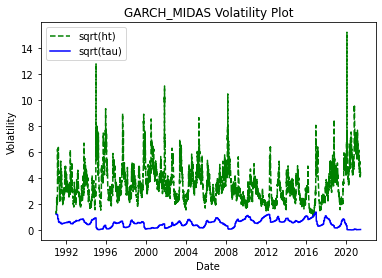

In [29]:
loglik, logliks, e, tau1, gt, ht, T =  GARCH_MIDAS(results_pd["x"].loc[index_min], 
                                                  returns_train, 
                                                  X_train_lags[f"data_column{index_min}"], 
                                                  index_min, 
                                                  full_output=True)

#Generate an array of time intervals
start_date = pd.to_datetime("1991-01-01")
time_intervals = np.array([t for t in range(T)])

#Generate an array of dates with business day frequency for the US
date_array = pd.date_range(start=start_date, periods=T, freq='B')

#Create a single figure with multiple subplots
fig, ax = plt.subplots()

#Plot the data on the same axis
ax.plot(date_array, np.sqrt(ht), 'g--', label='sqrt(ht)')
ax.plot(date_array, tau1, 'b-', label='sqrt(tau)')

#Add labels, title, legend, etc.
ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
ax.set_title('GARCH_MIDAS Volatility Plot')
ax.legend()

#Show the plot
plt.show()

In [30]:
np.std(tau1) #of single factor model (RV)

0.29427131114066857

In [31]:
tau1 

array([[1.23009608],
       [1.23009608],
       [1.23009608],
       ...,
       [0.05333608],
       [0.05333608],
       [0.05333608]])

In [32]:
summary_stats(GARCH_MIDAS, 
              T, 
              results_pd["x"].loc[index_min], 
              (returns_train, X_train_lags[f"data_column{index_min}"], index_min), 
              ['mu', 'alpha', 'beta', 'theta', 'omega', 'm'])

,mu,alpha,beta,theta,omega,m
values,0.050870,9.033975e-02,0.922015,-5.295173e-03,1.298380e+00,0.590376
p-val,0.053693,1.304377e-54,0.000000,6.651102e-22,2.138332e-41,0.016347


---
## Two-factors GARCH-MIDAS

In [35]:
X2_train = get_factors(data_train, 'diff_cpu', 36)
X2_test = get_factors(data_test, 'diff_cpu', 36)

In [36]:
X2_train_dict = {}
X2_test_dict = {}
X2_train_list = [0] * (12)


#modifying the get_opt_MLE function for 2 factors
def get_opt_MLE2(target_data, X , K, func = get_twofactor_tau): 
    #target_data is returns_train
    
    results_list = []
    
    #unpacking the tuple, X
    X_train_lags, X_train2_lags = X 
    
    for k in K:

        result = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                          args = (target_data, (X_train_lags[f"data_column{k}"], X_train2_lags[f"data_column{k}"]), k, func)) ## Limited Memory BFGS
        results_list.append(result)
    
    return pd.DataFrame(results_list, index = lag_variable)

Model 2: RV + CPU

In [38]:
X2_train_lags, X2_test_lags = get_X_dict(data_train, data_test, 'diff_cpu', lag_variable, pri_func = None)

In [39]:
## initial values - mu, alpha, beta, theta1, theta2, omega1, omega2, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 1, 1, -2])

results_pd2 = get_opt_MLE2(returns_train, (X_train_lags, X2_train_lags), lag_variable, func = get_twofactor_tau)

results_pd2

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_4165/2876430366.py:39: RuntimeWarning: invalid value encountered in log
  logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_4165/2876430366.py:33: RuntimeWarning: overflow encountered in double_scalars
  (1 - alpha - beta) + alpha*(e2[t-1]/tau[t]) + beta*gt[t-1])
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_4165/2876430366.py:36: RuntimeWarning: overflow encountered in multiply
  ht = np.multiply(tau,gt).flatten()


,fun,jac,nfev,njev,nit,status,message,x,success,hess_inv
3,21067.409011,"[0.0018189894032411148, -0.4158209778694526, -...",396,44,36,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.044820625884711064, 0.09412077011213824, 0....",True,<8x8 LbfgsInvHessProduct with dtype=float64>
6,20972.101871,"[-0.011277734300094912, -0.027284841067549383,...",585,65,37,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.06013178003064279, 0.08163480085237107, 0.9...",True,<8x8 LbfgsInvHessProduct with dtype=float64>
9,20804.679508,"[0.010186340658150243, 0.2171873348976931, 0.2...",369,41,34,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.05658059151407084, 0.09665371002048824, 0.9...",True,<8x8 LbfgsInvHessProduct with dtype=float64>
12,20619.903452,"[0.006912159732316236, -0.05093170332609218, -...",423,47,37,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.04623139831007144, 0.08923661135760841, 0.9...",True,<8x8 LbfgsInvHessProduct with dtype=float64>
15,20452.074786,"[-0.0025465851645375607, 0.11168594943650215, ...",369,41,33,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.0499825705875777, 0.09177958493015148, 0.92...",True,<8x8 LbfgsInvHessProduct with dtype=float64>
18,20293.085357,"[0.007275957612964459, -0.040745362660873745, ...",351,39,28,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.04520528088204543, 0.0947667641682554, 0.91...",True,<8x8 LbfgsInvHessProduct with dtype=float64>
21,20131.292374,"[-0.0010913936419446688, -0.02255546861584082,...",342,38,28,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.04528510485943659, 0.08995934757055896, 0.9...",True,<8x8 LbfgsInvHessProduct with dtype=float64>
24,19967.060517,"[0.0021827872838893377, -0.049840309683390205,...",603,67,54,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.04857601907551564, 0.09373058683807488, 0.9...",True,<8x8 LbfgsInvHessProduct with dtype=float64>
27,19798.798939,"[0.1473381416625303, -2.373053577114995, -1.89...",531,59,46,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.04553015315234956, 0.09343395511959302, 0.9...",True,<8x8 LbfgsInvHessProduct with dtype=float64>
30,19627.979043,"[-0.025465851645375605, 0.02546585166304609, 0...",387,43,28,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.0503278108555453, 0.09598578035220538, 0.91...",True,<8x8 LbfgsInvHessProduct with dtype=float64>


In [40]:
results_pd2.to_excel("params-RV-CPU.xlsx")

In [41]:
index_min2 = results_pd2["fun"].idxmin()

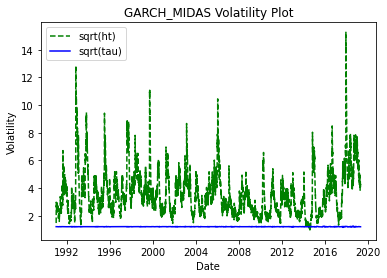

In [42]:
loglik, logliks, e, tau2, gt, ht, T =  GARCH_MIDAS(results_pd2["x"].loc[index_min2], 
                                                  returns_train, 
                                                  (X_train_lags[f"data_column{index_min2}"], X2_train_lags[f"data_column{index_min2}"]), 
                                                  index_min2, 
                                                  get_tau=get_twofactor_tau, 
                                                  full_output=True)



#Generate an array of time intervals
start_date = pd.to_datetime("1991-01-01")
time_intervals = np.array([t for t in range(T)])

#Generate an array of dates with business day frequency for the US
date_array = pd.date_range(start=start_date, periods=T, freq='B')

# # Create a single figure with multiple subplots
fig, ax = plt.subplots()

# # Plot the data on the same axis
ax.plot(date_array, np.sqrt(ht), 'g--', label='sqrt(ht)')
ax.plot(date_array, np.sqrt(tau2), 'b-', label='sqrt(tau)')

# # Add labels, title, legend, etc.
ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
ax.set_title('GARCH_MIDAS Volatility Plot')
ax.legend()

# # Show the plot
plt.show()

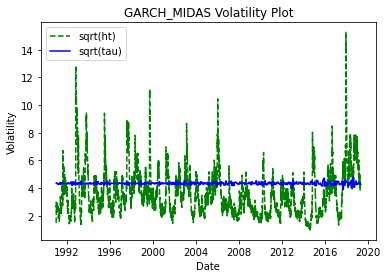

In [43]:
#Generate an array of time intervals
start_date = pd.to_datetime("1991-01-01")
time_intervals = np.array([t for t in range(T)])

#Generate an array of dates with business day frequency for the US
date_array = pd.date_range(start=start_date, periods=T, freq='B')

# # Create a single figure with multiple subplots
fig, ax = plt.subplots()

sum_tau2 = pd.DataFrame(tau2) + pd.DataFrame(tau2).shift(1)

# # Plot the data on the same axis
ax.plot(date_array, np.sqrt(ht), 'g--', label='sqrt(ht)')
ax.plot(date_array, np.sqrt(np.exp(sum_tau2)), 'b-', label='sqrt(tau)')

# # Add labels, title, legend, etc.
ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
ax.set_title('GARCH_MIDAS Volatility Plot')
ax.legend()

# # Show the plot
plt.show()

In [44]:
tau2

array([[1.47489343],
       [1.47489343],
       [1.47489343],
       ...,
       [1.45822776],
       [1.45822776],
       [1.45822776]])

In [45]:
np.std(np.sqrt(tau2)) #of 2 factor model (RV+CPU)

0.008927986812724012

In [46]:
summary_stats(GARCH_MIDAS, 
              T, 
              results_pd2["x"].loc[index_min2], 
              (returns_train, (X_train_lags[f"data_column{index_min2}"], X2_train_lags[f"data_column{index_min2}"]), index_min2, get_twofactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'omega1', 'omega2','m'])

,mu,alpha,beta,theta1,theta2,omega1,omega2,m
values,0.044605,9.051745e-02,0.920903,-0.004490,-0.004490,0.969575,0.969574,0.383646
p-val,0.089913,1.029908e-57,0.000000,0.454742,0.445632,0.454970,0.451930,0.011361


Model 3: RV + EMDAT

In [47]:
X3_train = get_factors(data_train, 'diff_monthly_disaster_freq', 36)
X3_test = get_factors(data_test, 'diff_monthly_disaster_freq', 36)

X3_train_dict = {}
X3_test_dict = {}
X3_train_list = [0] * (12)

X3_train_lags, X3_test_lags = get_X_dict(data_train, data_test, 'diff_monthly_disaster_freq', lag_variable, pri_func = None)

In [48]:
## initial values - mu, alpha, beta, theta1, theta2, omega1, omega2, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 1, 1, -2])

results_pd3 = get_opt_MLE2(returns_train, (X_train_lags, X3_train_lags), lag_variable, get_twofactor_tau)

results_pd3

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_4165/2876430366.py:33: RuntimeWarning: overflow encountered in double_scalars
  (1 - alpha - beta) + alpha*(e2[t-1]/tau[t]) + beta*gt[t-1])
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_4165/2876430366.py:39: RuntimeWarning: invalid value encountered in log
  logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))


,fun,jac,nfev,njev,nit,status,message,x,success,hess_inv
3,21061.872368,"[-0.16589183357558968, 1.0568328440164128, 1.7...",585,65,48,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.045168591043033904, 0.09265528512105838, 0....",True,<8x8 LbfgsInvHessProduct with dtype=float64>
6,20969.679493,"[0.007639755493612682, -0.0236468622585428, -0...",468,52,35,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.061146005369025515, 0.08214381617767447, 0....",True,<8x8 LbfgsInvHessProduct with dtype=float64>
9,20804.477065,"[0.16043486536586632, 2.3268512462406115, 5.07...",459,51,37,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.05799280227384279, 0.0965432157305152, 0.91...",True,<8x8 LbfgsInvHessProduct with dtype=float64>
12,20618.690905,"[-0.02582964952602383, 0.6300979297199404, 0.4...",594,66,53,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.047074163745567596, 0.08906374282295464, 0....",True,<8x8 LbfgsInvHessProduct with dtype=float64>
15,20452.181235,"[-0.005456968209723344, 0.019645085568635555, ...",432,48,33,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.04974972616744896, 0.09159037331947602, 0.9...",True,<8x8 LbfgsInvHessProduct with dtype=float64>
18,20288.841602,"[0.0014551915225928917, -0.010186340665218436,...",558,62,46,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.04687737435070871, 0.09376615653168746, 0.9...",True,<8x8 LbfgsInvHessProduct with dtype=float64>
21,20128.319453,"[0.11714291756872779, -0.7694325181048925, -0....",666,74,54,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.04594257694621711, 0.0895560530540682, 0.92...",True,<8x8 LbfgsInvHessProduct with dtype=float64>
24,19967.812133,"[-0.0014551915225928917, 0.035652192328264526,...",414,46,34,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.049165603269230106, 0.0937648467854737, 0.9...",True,<8x8 LbfgsInvHessProduct with dtype=float64>
27,19799.150935,"[0.052386894813344104, 0.09058567234426396, 0....",306,34,25,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.04632953224190514, 0.09348565156157679, 0.9...",True,<8x8 LbfgsInvHessProduct with dtype=float64>
30,19624.871420,"[1.0521034708346608, 0.9320501708674869, 2.596...",639,71,49,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.05251217051892357, 0.09607409615115668, 0.9...",True,<8x8 LbfgsInvHessProduct with dtype=float64>


In [49]:
results_pd3.to_excel("params-RV-EMDAT.xlsx")

In [50]:
index_min3 = results_pd3["fun"].idxmin()

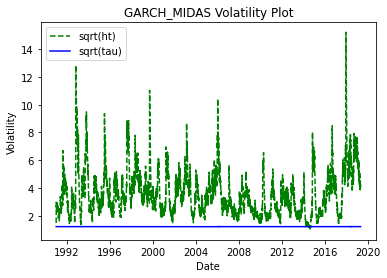

In [51]:
loglik, logliks, e, tau3, gt, ht, T =  GARCH_MIDAS(results_pd3["x"].loc[index_min3], 
                                                  returns_train, 
                                                      (X_train_lags[f"data_column{index_min3}"], 
                                                       X3_train_lags[f"data_column{index_min3}"]), 
                                                  index_min3,  #select lowest value from MLE obj fn
                                                  get_tau=get_twofactor_tau, 
                                                  full_output=True)


# # Create a single figure with multiple subplots
fig, ax = plt.subplots()

# # Plot the data on the same axis
ax.plot(date_array, np.sqrt(ht), 'g--', label='sqrt(ht)')
ax.plot(date_array, np.sqrt(tau3), 'b-', label='sqrt(tau)')

# # Add labels, title, legend, etc.
ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
ax.set_title('GARCH_MIDAS Volatility Plot')
ax.legend()

# # Show the plot
plt.show()

In [52]:
tau3

array([[1.47639585],
       [1.47639585],
       [1.47639585],
       ...,
       [1.4742843 ],
       [1.4742843 ],
       [1.4742843 ]])

In [53]:
np.std(np.sqrt(tau3)) #of 2 factor model (RV+EMDAT)

0.0027359799698330645

In [54]:
summary_stats(GARCH_MIDAS, 
              T, 
              results_pd3["x"].loc[index_min3], 
              (returns_train, (X_train_lags[f"data_column{index_min3}"], X3_train_lags[f"data_column{index_min3}"]), index_min3, get_twofactor_tau), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'omega1', 'omega2','m'])

,mu,alpha,beta,theta1,theta2,omega1,omega2,m
values,0.044509,9.018697e-02,0.92115,0.006152,0.006152,1.053703e+00,1.053703e+00,0.388904
p-val,0.086910,6.506209e-57,0.00000,0.474935,0.474935,5.651874e-23,5.651874e-23,0.010415


In [55]:
X4_train = get_factors(data_train, 'WTI_ret', 36)
X4_test = get_factors(data_test, 'WTI_ret', 36)

X4_train_dict = {}
X4_test_dict = {}
X4_train_list = [0] * (12)

X4_train_lags, X4_test_lags = get_X_dict(data_train, data_test, "WTI_ret", lag_variable, pri_func = None)

---
## Three-Factors GARCH-MIDAS
Model 5: RV + CPU + EMDAT, K = 36

In [63]:
#modifying the get_opt_MLE function for 3 factors

def get_opt_MLE3(target_data, X , K, func = get_threefactor_tau): 
    #target_data is returns_train
    
    results_list = []
    
    #unpacking the tuple, X
    X_train_lags, X_train2_lags, X_train3_lags = X 
    
    for k in K:

        result = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                          args = (target_data, 
                                      (X_train_lags[f"data_column{k}"], 
                                       X_train2_lags[f"data_column{k}"], 
                                       X_train3_lags[f"data_column{k}"]
                                      ), 
                                  k, 
                                  func)
                         ) ## Limited Memory BFGS
        results_list.append(result)
    
    return pd.DataFrame(results_list, index = lag_variable)

In [64]:
## initial values - mu, alpha, beta, theta1, theta2, theta3, omega1, omega2, omega3, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 0.1, 1, 1, 1, -2])

fac3_results_pd = get_opt_MLE3(returns_train, 
                               (X_train_lags, X2_train_lags, X3_train_lags), 
                               lag_variable,
                              func = get_threefactor_tau)

fac3_results_pd

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_4165/2876430366.py:33: RuntimeWarning: overflow encountered in double_scalars
  (1 - alpha - beta) + alpha*(e2[t-1]/tau[t]) + beta*gt[t-1])
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_4165/2876430366.py:39: RuntimeWarning: invalid value encountered in log
  logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))


,fun,jac,nfev,njev,nit,status,message,x,success,hess_inv
3,21065.210592,"[-0.0025465851645375607, -0.08076312955994618,...",649,59,42,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.04324755563285749, 0.09435565765286402, 0.9...",True,<10x10 LbfgsInvHessProduct with dtype=float64>
6,20971.443679,"[-0.01236912794203958, -0.1295120456006344, -0...",726,66,49,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.05947428426450305, 0.08172519815052372, 0.9...",True,<10x10 LbfgsInvHessProduct with dtype=float64>
9,20804.687227,"[0.009458744896853796, 0.8090864871230644, 1.3...",693,63,35,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.057063605570225856, 0.09697900202503465, 0....",True,<10x10 LbfgsInvHessProduct with dtype=float64>
12,20617.675633,"[0.16261765264975567, 0.12732925831523045, 0.0...",858,78,63,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.044106187162929224, 0.08963175710383027, 0....",True,<10x10 LbfgsInvHessProduct with dtype=float64>
15,20451.378109,"[-0.00873114913555735, 0.06766640584752247, 0....",539,49,39,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.04841847205815908, 0.09169654224957176, 0.9...",True,<10x10 LbfgsInvHessProduct with dtype=float64>
18,20293.319004,"[0.06621121427797658, -2.154411050693699, -3.6...",484,44,30,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.045374240200088095, 0.0946454539331528, 0.9...",True,<10x10 LbfgsInvHessProduct with dtype=float64>
21,20131.266988,"[-0.0032741809258340065, -0.007639755498913828...",407,37,27,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.04527878463477719, 0.08979420165257485, 0.9...",True,<10x10 LbfgsInvHessProduct with dtype=float64>
24,19969.180318,"[0.0, -0.015643308878728314, -0.02837623455273...",440,40,30,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.048388196430737954, 0.09396619684710422, 0....",True,<10x10 LbfgsInvHessProduct with dtype=float64>
27,19799.922464,"[0.016734702509818254, -0.13751559898044888, -...",429,39,30,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.0455513428860686, 0.09356041123775594, 0.91...",True,<10x10 LbfgsInvHessProduct with dtype=float64>
30,19626.879521,"[0.05966285242630856, 0.07385096982283366, 0.2...",814,74,52,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.048509091002333304, 0.09572677182803586, 0....",True,<10x10 LbfgsInvHessProduct with dtype=float64>


In [65]:
fac3_results_pd.to_excel("params-CPU-RV-EMDAT.xlsx")

In [66]:
index_min_fac3 = fac3_results_pd["fun"].idxmin()

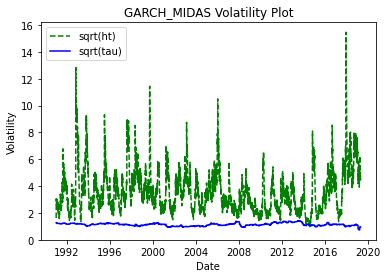

In [67]:
loglik, logliks, e, tau5, gt, ht, T =  GARCH_MIDAS(fac3_results_pd['x'].loc[index_min_fac3], 
                                                  returns_train, 
                                                      (X_train_lags[f"data_column{index_min_fac3}"], 
                                                       X2_train_lags[f"data_column{index_min_fac3}"], 
                                                       X3_train_lags[f"data_column{index_min_fac3}"]), 
                                                  index_min_fac3, 
                                                  get_tau=get_threefactor_tau, 
                                                  full_output=True
                                                 )



#Create a single figure with multiple subplots
fig, ax = plt.subplots()

#Plot the data on the same axis
ax.plot(date_array, np.sqrt(ht), 'g--', label='sqrt(ht)')
ax.plot(date_array, np.sqrt(tau5), 'b-', label='sqrt(tau)')

#Add labels, title, legend
ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
ax.set_title('GARCH_MIDAS Volatility Plot')
ax.legend()

#Show the plot
plt.show()

In [68]:
tau5

array([[1.61578093],
       [1.61578093],
       [1.61578093],
       ...,
       [0.90510251],
       [0.90510251],
       [0.90510251]])

In [69]:
np.std(np.sqrt(tau5)) #of 3 factor model, w/o WTI

0.10641716167259885

In [70]:
summary_stats(GARCH_MIDAS, 
              T, 
                    fac3_results_pd['x'].loc[index_min_fac3], 
              (returns_train,
                (
                    X_train_lags[f"data_column{index_min_fac3}"], 
                    X2_train_lags[f"data_column{index_min_fac3}"], 
                    X3_train_lags[f"data_column{index_min_fac3}"]
                ), 
                    index_min_fac3, 
                    get_threefactor_tau
              ), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'theta3', 'omega1', 'omega2', 'omega3', 'm']
             )

,mu,alpha,beta,theta1,theta2,theta3,omega1,omega2,omega3,m
values,0.044482,9.199165e-02,0.919833,-1.019299,-1.019299,-1.019298,0.749796,0.749796,0.749796,0.298179
p-val,0.089107,1.590393e-56,0.000000,0.493280,0.493280,0.407999,0.061361,0.061361,0.015342,0.047056


# Four-Factors GARCH-MIDAS
Model 6: RV + CPU + EMDAT + WTI, K = 36

In [71]:
#modifying the get_opt_MLE function for 4 factors

def get_opt_MLE3(target_data, X , K, func = get_fourfactor_tau): 
    #target_data is returns_train

    results_list = []
    
    #unpacking the tuple, X
    X_train_lags, X_train2_lags, X_train3_lags, X_train4_lags = X 
    
    for k in K:

        result = minimize(GARCH_MIDAS, x0=x0, method='L-BFGS-B',\
                          args = (target_data, 
                                      (X_train_lags[f"data_column{k}"], 
                                       X_train2_lags[f"data_column{k}"], 
                                       X_train3_lags[f"data_column{k}"],
                                       X_train4_lags[f"data_column{k}"]
                                      ), 
                                  k, 
                                  func)
                         ) ## Limited Memory BFGS
        results_list.append(result)
    
    return pd.DataFrame(results_list, index = lag_variable)

In [72]:
## initial values - mu, alpha, beta, theta1, theta2, theta3, theta4, omega1, omega2, omega3, omgega4, m
x0 = np.array([0.0005, 0.09, 0.90, 0.1, 0.1, 0.1, 0.1, 1, 1, 1, 1, -2])

fac4_results_pd = get_opt_MLE3(returns_train, 
                               (X_train_lags, X2_train_lags, X3_train_lags, X4_train_lags), 
                               lag_variable,
                              func = get_fourfactor_tau)

fac4_results_pd

/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_4165/2876430366.py:33: RuntimeWarning: overflow encountered in double_scalars
  (1 - alpha - beta) + alpha*(e2[t-1]/tau[t]) + beta*gt[t-1])
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_4165/2876430366.py:39: RuntimeWarning: invalid value encountered in log
  logliks = 0.5*(np.log(2*pi)+np.log(ht)+(e2/ht))
/var/folders/sx/0ywwv5tn1p5_9wh22hh6g2tm0000gn/T/ipykernel_4165/2876430366.py:36: RuntimeWarning: overflow encountered in multiply
  ht = np.multiply(tau,gt).flatten()


,fun,jac,nfev,njev,nit,status,message,x,success,hess_inv
3,21065.212806,"[-0.03237801137769184, -0.024010660139443456, ...",780,60,43,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.043226518044200336, 0.0943533644536552, 0.9...",True,<12x12 LbfgsInvHessProduct with dtype=float64>
6,20971.448789,"[0.0443833414390832, 0.5558831620162061, 0.148...",949,73,51,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.05955907476485507, 0.08174574174189211, 0.9...",True,<12x12 LbfgsInvHessProduct with dtype=float64>
9,20804.686528,"[0.008003553374260905, 0.20954757939877927, 0....",754,58,36,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.05706159287718602, 0.09698287333095647, 0.9...",True,<12x12 LbfgsInvHessProduct with dtype=float64>
12,20618.286764,"[0.08658389559427707, -1.008811523737526, -1.5...",572,44,33,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.04326474436253525, 0.08943759949199867, 0.9...",True,<12x12 LbfgsInvHessProduct with dtype=float64>
15,20451.516275,"[0.008367351254909127, 0.16916601461880618, 0....",533,41,31,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.04881512557272779, 0.09146820678604875, 0.9...",True,<12x12 LbfgsInvHessProduct with dtype=float64>
18,20293.078409,"[-0.14042598193021405, 0.1862645150211371, -0....",741,57,45,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.044797967778022134, 0.09457221383677894, 0....",True,<12x12 LbfgsInvHessProduct with dtype=float64>
21,20131.265220,"[-0.0021827872838893377, 0.0061845639753111935...",481,37,27,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.04531360406835981, 0.08974948008431799, 0.9...",True,<12x12 LbfgsInvHessProduct with dtype=float64>
24,19969.194988,"[0.017098500390466478, 0.6115442377940068, 0.9...",507,39,29,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.04842649664356784, 0.09394153745676977, 0.9...",True,<12x12 LbfgsInvHessProduct with dtype=float64>
27,19797.242432,"[0.0003637978806482229, -0.031650415638357285,...",1209,93,70,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.04477393493058479, 0.09318059570167124, 0.9...",True,<12x12 LbfgsInvHessProduct with dtype=float64>
30,19626.961638,"[-0.4642060957071325, -0.5402398531374778, -0....",637,49,34,0,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,"[0.04811913769552585, 0.0957515298170293, 0.91...",True,<12x12 LbfgsInvHessProduct with dtype=float64>


In [73]:
fac4_results_pd.to_excel("params-CPU-RV-EMDAT-WTI.xlsx")

In [74]:
index_min_fac4 = fac4_results_pd["fun"].idxmin()

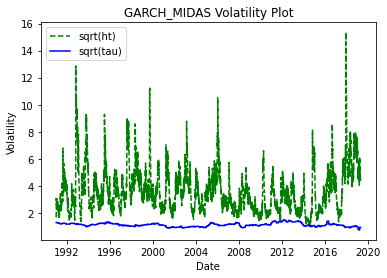

In [75]:
loglik, logliks, e, tau6, gt, ht, T =  GARCH_MIDAS(fac4_results_pd['x'].loc[index_min_fac4], 
                                                  returns_train, 
                                                      (X_train_lags[f"data_column{index_min_fac4}"], 
                                                       X2_train_lags[f"data_column{index_min_fac4}"], 
                                                       X3_train_lags[f"data_column{index_min_fac4}"],
                                                       X4_train_lags[f"data_column{index_min_fac4}"]), 
                                                  index_min_fac4, 
                                                  get_tau=get_fourfactor_tau, 
                                                  full_output=True
                                                 )



#Create a single figure with multiple subplots
fig, ax = plt.subplots()

#Plot the data on the same axis
ax.plot(date_array, np.sqrt(ht), 'g--', label='sqrt(ht)')
ax.plot(date_array, np.sqrt(tau6), 'b-', label='sqrt(tau)')

#Add labels, title, legend
ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
ax.set_title('GARCH_MIDAS Volatility Plot')
ax.legend()

#Show the plot
plt.show()

In [76]:
index_min_fac4

36

In [77]:
fac4_results_pd["x"][index_min_fac4]

array([ 0.04372486,  0.0924636 ,  0.91952551, -1.00612367, -1.00607691,
       -1.00607691, -1.00607691,  0.94899727,  0.94899702,  0.94899702,
        0.94899702,  0.273675  ])

In [78]:
tau6

array([[1.65662023],
       [1.65662023],
       [1.65662023],
       ...,
       [0.85401025],
       [0.85401025],
       [0.85401025]])

In [79]:
np.std(np.sqrt(tau6)) #of 4 factor model

0.13189154743594977

In [80]:
summary_stats(GARCH_MIDAS, 
              T, 
                    fac4_results_pd['x'].loc[index_min_fac4], 
              (returns_train,
                (
                    X_train_lags[f"data_column{index_min_fac4}"], 
                    X2_train_lags[f"data_column{index_min_fac4}"], 
                    X3_train_lags[f"data_column{index_min_fac4}"],
                    X4_train_lags[f"data_column{index_min_fac4}"]
                ), 
                    index_min_fac4, 
                    get_fourfactor_tau
              ), 
              ['mu', 'alpha', 'beta', 'theta1', 'theta2', 'theta3', 'theta4', 'omega1', 'omega2', 'omega3', 'omega4', 'm']
             )

,mu,alpha,beta,theta1,theta2,theta3,theta4,omega1,omega2,omega3,omega4,m
values,0.043725,9.246360e-02,0.919526,-1.006124,-1.006077,-1.006077,-1.006077,0.948997,0.948997,0.948997,0.948997,0.273675
p-val,0.094021,1.711439e-57,0.000000,0.345063,0.347181,0.347181,0.347181,0.019440,0.018978,0.018978,0.018978,0.066635


---